In [19]:
!pip install transformers bertopic pandas matplotlib seaborn torch
!pip install emoji -q

import emoji
import pandas as pd
import numpy as np
from google.colab import drive
from transformers import pipeline
from bertopic import BERTopic
import torch
from tqdm.auto import tqdm

In [20]:
from google.colab import drive
import os

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
file_path = '/content/drive/My Drive/SOSC314/Fox Dataset/Fox_Comment_Details.csv'
df = pd.read_csv(file_path)

In [22]:
# Data cleaning: Remove null values, conversion time
df = df.dropna(subset=['comment_text'])
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.dropna(subset=['timestamp'])

# trial 10000
#df = df.sample(10000, random_state=42).reset_index(drop=True)

print(f"Total comments to analyze: {len(df)}")

Total comments to analyze: 126727


In [23]:
# ==========================================
# 2. Data Loading and Preprocessing (Revised Version)
# ==========================================

# 1. 1. Replace _x000D_ with a blank or space
df['comment_text'] = df['comment_text'].str.replace(r'_x000D_', ' ', regex=True)

# 2. Incidentally, handle other common escape characters (optional)
df['comment_text'] = df['comment_text'].str.replace(r'\n', ' ', regex=True) # Handle line breaks
df['comment_text'] = df['comment_text'].str.replace(r'\s+', ' ', regex=True) # Merge multiple Spaces into one

df = df.dropna(subset=['comment_text'])
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.dropna(subset=['timestamp'])

print(f"Cleaned! Total comments: {len(df)}")

Cleaned! Total comments: 126727


In [24]:
import re

emoji_pattern = re.compile(r'[^\x00-\x7F]+')

# 3. 统计并筛选
df['has_emoji'] = df['comment_text'].apply(lambda x: bool(emoji_pattern.search(str(x))))
emoji_df = df[df['has_emoji'] == True]

print(f"--- 重新检测结果 ---")
print(f"找到含有 Emoji 或特殊字符的评论总数: {len(emoji_df)} 条")

# 4. 抽取 10 条来看看，确认是否包含你想要的 😂 😢 🤷🏼‍♂️
print("\n前 10 条检测到的评论示例：")
for idx, text in enumerate(emoji_df['comment_text'].head(10)):
    print(f"{idx+1}. {text}")

--- 重新检测结果 ---
找到含有 Emoji 或特殊字符的评论总数: 26583 条

前 10 条检测到的评论示例：
1. Need to vote out Demorats in 2026😊
2. Trump ❤
3. FILIBUSTER GOTTA GO 😂😂😂😂
4. Thanks Foxnews Foxnews the best ❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤❤
5. OBEY OR DIE 🎉
6. 1of3 MAGA Rages at Mike Pence for Torching Trump’s Tariffs as ‘Largest Peacetime Tax Hike in History’ April 3, 2025 This news article was published by DAILY BEAST. The MAGAverse raged at former Vice President Mike Pence after he blasted President Donald Trump’s tariffs as the “largest peacetime tax in U.S. history.” “These tariffs are nearly 10 times the size of those imposed during the Trump-Pence administration and will cost American families over $3,500 per year,” he wrote in a social media post that highlighted research from the Advancing American Freedom Foundation. That increase will “easily erase three years’ worth of pay raises” for most American families, the document said. On Wednesday, Trump announced universal tariffs, a type of import tax paid by U.S. companies w

In [25]:

# ==========================================
# 3. Multi-emotion Recognition (Emotion Analysis)
# ==========================================
print("Initializing Emotion Classifier...")
# 使用 GPU (device=0) 进行加速
emotion_model = pipeline(
    "text-classification",
    model="j-hartmann/emotion-english-distilroberta-base",
    return_all_scores=False,
    device=0
)

def batch_emotion_analysis(texts, batch_size=64):
    results = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Analyzing Emotions"):
        batch = texts[i:i+batch_size]

        # Core Fix: Add the truncation parameter when calling
        try:
            batch_results = emotion_model(
                [str(t) for t in batch],
                truncation=True,
                max_length=512
            )
            results.extend([res['label'] for res in batch_results])
        except Exception as e:
            print(f"Error at batch {i}: {e}")
            #If an Error still occurs in a certain batch, you can fill it with 'Neutral' or' Error' to ensure consistent lengths
            results.extend(['Neutral'] * len(batch))

    return results
#sentiment analysis
df['emotion'] = batch_emotion_analysis(df['comment_text'].tolist())

Initializing Emotion Classifier...


Loading weights:   0%|          | 0/105 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: j-hartmann/emotion-english-distilroberta-base
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Analyzing Emotions:   0%|          | 0/1981 [00:00<?, ?it/s]

In [26]:
def batch_emotion_analysis_with_scores(texts, batch_size=64):
    labels = []
    scores = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Analyzing Emotions"):
        batch = [str(t)[:512] for t in texts[i:i+batch_size]]
        try:
            # batch_results here will contain [{' label ':' anger (', 'score: 0.99},...
            batch_results = emotion_model(batch, truncation=True, max_length=512)
            labels.extend([res['label'] for res in batch_results])
            scores.extend([res['score'] for res in batch_results])
        except Exception as e:
            print(f"Error at batch {i}: {e}")
            labels.extend(['neutral'] * len(batch))
            scores.extend([0.0] * len(batch))
    return labels, scores

# Execute and save two columns
df['emotion_label'], df['emotion_score'] = batch_emotion_analysis_with_scores(df['comment_text'].tolist())

Analyzing Emotions:   0%|          | 0/1981 [00:00<?, ?it/s]

In [29]:
# Get all the non-repetitive emotion labels
unique_emotions = df['emotion_label'].unique()

print("=== Top Confidence comments for each emotion ===\n")

for emotion in unique_emotions:
    print(f"【Emotion category: {emotion.upper()}】")

    #Filter this emotion and sort it from high to low by score
    #Here we get top 5 comments with highest scores
    top_comments = df[df['emotion_label'] == emotion].sort_values(by='emotion_score', ascending=False).head(5)

    for i, (idx, row) in enumerate(top_comments.iterrows()):
        print(f"{i+1}. [Confidence score: {row['emotion_score']:.4f}]")
        print(f"   Full Comment: {row['comment_text']}")
        print()
    print("-" * 80)

=== Top Confidence comments for each emotion ===

【Emotion category: NEUTRAL】
1. [Confidence score: 0.9772]
   Full Comment: It's time to give the democrats what they want. Ice needs to shoot 1st and ask questions later.

2. [Confidence score: 0.9749]
   Full Comment: Federal immigration enforcement is normal. If more officers are needed so be it.

3. [Confidence score: 0.9744]
   Full Comment: Maybe you should share this piece with Jessica and she can recap her stuff that she said on the five

4. [Confidence score: 0.9744]
   Full Comment: Just deploy them, it’s the only way ice will be safe.

5. [Confidence score: 0.9743]
   Full Comment: You can only hope that those people would swallow those whistles or have them stuck somewhere else

--------------------------------------------------------------------------------
【Emotion category: ANGER】
1. [Confidence score: 0.9944]
   Full Comment: i feel like ice is doing everything they could to provoke.why can't they just do their job and le

In [31]:
# ==========================================
# 4. Dynamic Topic Modeling (Make corrections at the step of Dynamic Topic modeling)(vectorized)
# ==========================================
from sklearn.feature_extraction.text import CountVectorizer

print("Running BERTopic with optimized Vectorizer...")

# Define the Vectorizer before the model initialization
#This will filter out "the", "is", "of", etc. in the hashtags and allow two-word phrases like "ice agents" to appear
vectorizer_model = CountVectorizer(
    stop_words="english",
    ngram_range=(1, 2),
    min_df=10
)

# Pass in vectorizer_model when initializing the model
topic_model = BERTopic(
    vectorizer_model=vectorizer_model,
    language="english",
    calculate_probabilities=False,
    verbose=True
)

# Perform fitting
topics, probs = topic_model.fit_transform(df['comment_text'].tolist())

df['topic'] = topics

# Then proceed with the analysis of the time dimension.
timestamps = df['timestamp'].tolist()
topics_over_time = topic_model.topics_over_time(df['comment_text'].tolist(), timestamps)

2026-02-03 08:11:17,182 - BERTopic - Embedding - Transforming documents to embeddings.


Running BERTopic with optimized Vectorizer...


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Batches:   0%|          | 0/3961 [00:00<?, ?it/s]

2026-02-03 08:12:43,111 - BERTopic - Embedding - Completed ✓
2026-02-03 08:12:43,113 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2026-02-03 08:15:12,761 - BERTopic - Dimensionality - Completed ✓
2026-02-03 08:15:12,765 - BERTopic - Cluster - Start clustering the reduced embeddings
2026-02-03 08:15:30,645 - BERTopic - Cluster - Completed ✓
2026-02-03 08:15:30,688 - BERTopic - Representation - Fine-tuning topics using representation models.
2026-02-03 08:15:38,513 - BERTopic - Representation - Completed ✓
61it [00:18,  3.27it/s]


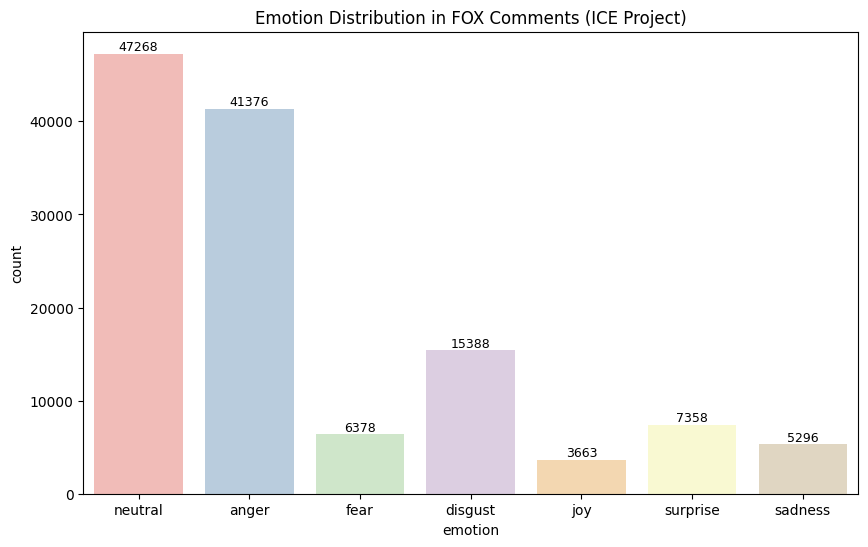

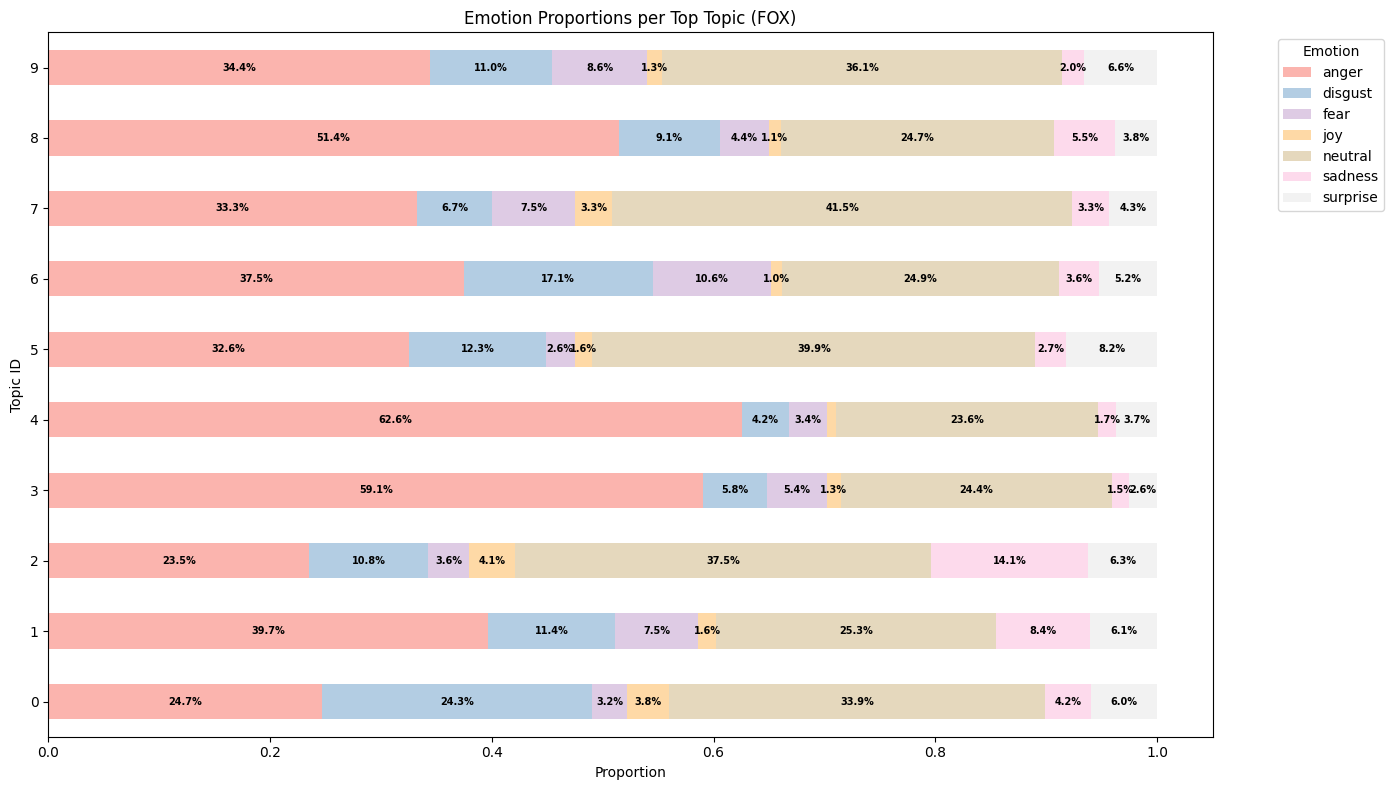

Analysis complete. Results saved to /content/drive/My Drive/SOSC314/Fox Dataset/FOX_DTM_Analysis_Results.csv


In [43]:
# ==========================================
# 5. Visualization and result export
# ==========================================

# A. A diagram of the evolution of the theme over time
fig_topic_time = topic_model.visualize_topics_over_time(topics_over_time)
fig_topic_time.show()

# B. Emotion distribution statistics
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='emotion', palette='Pastel1') # Changed palette to 'Pastel1'
plt.title('Emotion Distribution in FOX Comments (ICE Project)')

# Add count labels on top of the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=9, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()

# C. Theme - Emotion Cross-Analysis (Key: See which topics make people the angrier/most frightened)
# Filter out the top 10 popular topics (excluding topic -1 which is noise)
top_10_topics = df['topic'].value_counts().iloc[1:11].index.tolist()
df_top_filtered = df[df['topic'].isin(top_10_topics)]

# Calculate emotion proportions for each of the top topics
emotion_proportions = df_top_filtered.groupby('topic')['emotion'].value_counts(normalize=True).unstack(fill_value=0)

# Ensure topics are ordered by frequency for consistent visualization
emotion_proportions = emotion_proportions.loc[top_10_topics]

plt.figure(figsize=(14, 8))
ax_prop = emotion_proportions.plot(kind='barh', stacked=True, colormap='Pastel1', ax=plt.gca()) # Changed colormap to 'Pastel1'
plt.title('Emotion Proportions per Top Topic (FOX)')
plt.xlabel('Proportion')
plt.ylabel('Topic ID')

# Add percentage labels to each segment
for container in ax_prop.containers:
    for patch in container.patches:
        width = patch.get_width()
        if width > 0.01: # Only label if there's a significant segment
            x = patch.get_x() + width / 2
            y = patch.get_y() + patch.get_height() / 2
            ax_prop.text(x, y, f'{width:.1%}', ha='center', va='center',
                         fontsize=7, color='black', weight='bold')

plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# D. Export results
output_path = '/content/drive/My Drive/SOSC314/Fox Dataset/FOX_DTM_Analysis_Results.csv'
df.to_csv(output_path, index=False)
print(f"Analysis complete. Results saved to {output_path}")